In [1]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns
from pypfopt.risk_models import CovarianceShrinkage

In [2]:
# Configurations and Paramters
# list of diversified assets
tickers = ["SPY", "AGG", "GLD", "VNQ", "MSFT", "JPM"] 
benchmark_ticker = "SPY"

# Strategy Parameters
rebalance_frequency = 3 # Quarterly rebalancing
rolling_window = 36 # 3 years of data for optimization

In [7]:
# final, improved backtesting code
# --- Data Download ---
all_tickers = list(set(tickers + [benchmark_ticker]))
all_data = yf.download(all_tickers, start="2012-01-01", end="2024-12-31")['Close']

# --- Data Preparation ---
monthly_returns = all_data.resample('ME').last().pct_change().dropna()
asset_returns = monthly_returns[tickers]
benchmark_returns = monthly_returns[benchmark_ticker]

# --- Backtesting Loop ---
portfolio_returns = []
dates = []
all_weights = []

# Calculate a 12-month simple moving average on the benchmark (SPY)
# We use monthly data, so a 12-period MA is similar to a 200-day MA
spy_ma = monthly_returns['SPY'].rolling(window=12).mean()

for i in range(rolling_window, len(monthly_returns) - rebalance_frequency, rebalance_frequency):
    
    current_window_returns = monthly_returns.iloc[i - rolling_window : i]
    
    mu = expected_returns.ema_historical_return(current_window_returns[tickers], frequency=12)
    S = CovarianceShrinkage(current_window_returns[tickers], frequency=12).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.40)) 
    
    # try:
    #     weights = ef.max_sharpe()
    #     cleaned_weights = ef.clean_weights()
    #     all_weights.append(cleaned_weights)
    # --- THIS IS THE NEW PART: THE REGIME FILTER ---
    # Get the most recent price and moving average before the optimization period
    last_spy_price = monthly_returns['SPY'].iloc[i-1]
    current_spy_ma = spy_ma.iloc[i-1]

    try:
        if last_spy_price > current_spy_ma:
            # "Risk-On" regime: Aim for growth
            weights = ef.max_sharpe()
    except Exception as e:
        if all_weights:
             cleaned_weights = all_weights[-1]
        else:
             continue

    hold_start = i
    hold_end = i + rebalance_frequency
    holding_period_returns = asset_returns.iloc[hold_start:hold_end]
    
    weights_series = pd.Series(cleaned_weights)
    period_portfolio_return = (holding_period_returns * weights_series).sum(axis=1)
    
    portfolio_returns.extend(period_portfolio_return)
    dates.extend(period_portfolio_return.index)

backtest_results = pd.Series(portfolio_returns, index=dates)

C:\Users\nikib\AppData\Local\Temp\ipykernel_22844\534287572.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start="2012-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  6 of 6 completed


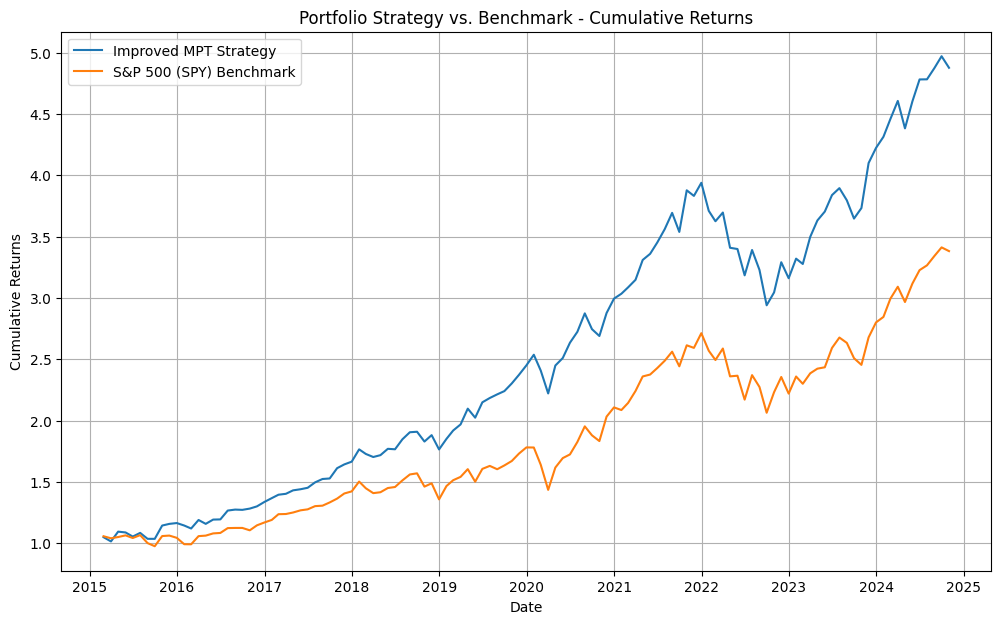

In [8]:
# Plotting and Analysis
aligned_benchmark = benchmark_returns.loc[backtest_results.index]
cumulative_strategy_returns = (1 + backtest_results).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

plt.figure(figsize=(12, 7))
plt.plot(cumulative_strategy_returns, label='Improved MPT Strategy')
plt.plot(cumulative_benchmark_returns, label='S&P 500 (SPY) Benchmark')
plt.title('Portfolio Strategy vs. Benchmark - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()